# Read realtime data from IOOS Sensor Map via ERDDAP tabledap

Web Map Services are a great way to find data you may be looking for in a particular geographic area.

Suppose you were exploring the [IOOS Sensor Map](https://via.hypothes.is/https://sensors.ioos.us/#map),
and after selecting Significant Wave Height,
had selected buoy 44011 on George's Bank:

![2017-03-27_16-21-08](https://cloud.githubusercontent.com/assets/1872600/24376518/213e6c4c-130a-11e7-9744-2f23e9660adf.png)

You click the `ERDDAP` link and generate a URL to download the data as `CSV` ![2017-03-27_16-24-35](https://cloud.githubusercontent.com/assets/1872600/24376521/2377afc8-130a-11e7-9a3b-c1c46e43d20d.png).

You notice that the URL that is generated

[`http://erddap.axiomdatascience.com/erddap/tabledap/sensor_service.csvp?time,depth,station,parameter,unit,value&time>=2017-02-27T12:00:00Z&station="urn:ioos:station:wmo:44011"&parameter="Significant Wave Height"&unit="m"`](http://erddap.axiomdatascience.com/erddap/tabledap/sensor_service.csvp?time,depth,station,parameter,unit,value&time>=2017-02-27T12:00:00Z&station="urn:ioos:station:wmo:44011"&parameter="Significant Wave Height"&unit="m")

is fairly easy to understand,
and that a program could construct that URL fairly easily.
Let's explore how that could work...

In [1]:
import requests
from urllib.parse import urlencode


def encode_erddap(urlbase, fname, columns, params):
    """
    urlbase: the base string for the endpoint
             (e.g.: http://erddap.axiomdatascience.com/erddap/tabledap).
    fname: the data source (e.g.: `sensor_service`) and the response (e.g.: `.csvp` for CSV).
    columns: the columns of the return table.
    params: the parameters for the query.

    Returns a valid ERDDAP endpoint.
    """
    urlbase = urlbase.rstrip('/')
    if not urlbase.lower().startswith(('http:', 'https:')):
        msg = 'Expected valid URL but got {}'.format
        raise ValueError(msg(urlbase))

    columns = ','.join(columns)
    params = urlencode(params)
    endpoint = '{urlbase}/{fname}?{columns}&{params}'.format

    url = endpoint(urlbase=urlbase, fname=fname,
                   columns=columns, params=params)
    r = requests.get(url)
    r.raise_for_status()
    return url

Using the function we defined above, we can now bypass the forms and get the data by generating the URL "by hand". Below we have a query for `Significant Wave Height` from buoy `44011`, a buoy on George's Bank off the coast of Cape Cod, MA, starting at the beginning of the year 2017.

\* For more information on how to use tabledap, please check the [NOAA ERDDAP documentation](https://via.hypothes.is/http://coastwatch.pfeg.noaa.gov/erddap/tabledap/documentation.html) for more information on the various parameters and responses of ERDDAP.

In [2]:
from urllib.parse import unquote


urlbase = 'http://erddap.axiomdatascience.com/erddap/tabledap'

fname = 'sensor_service.csvp'

columns = ('time',
           'value',
           'station',
           'longitude',
           'latitude',
           'parameter',
           'unit',
           'depth')
params = {
    # Inequalities do not exist in HTTP parameters,
    # so we need to hardcode the `>` in the time key to get a '>='.
    # Note that a '>' or '<' cannot be encoded with `urlencode`, only `>=` and `<=`.
    'time>': '2017-01-00T00:00:00Z',
    'station': '"urn:ioos:station:wmo:44011"',
    'parameter': '"Significant Wave Height"',
    'unit': '"m"',
}

url = encode_erddap(urlbase, fname, columns, params)

print(unquote(url))

http://erddap.axiomdatascience.com/erddap/tabledap/sensor_service.csvp?time,value,station,longitude,latitude,parameter,unit,depth&time>=2017-01-00T00:00:00Z&station="urn:ioos:station:wmo:44011"&parameter="Significant+Wave+Height"&unit="m"


Here is a cool part about ERDDAP `tabledap` - The data `tabledap` `csvp` response can be easily read by Python's pandas `read_csv` function.

In [3]:
from pandas import read_csv

df = read_csv(url, index_col=0, parse_dates=True)

# Prevent :station: from turning into an emoji in the webpage.
df['station'] = df.station.str.split(':').str.join('_')

df.head()

,value,station,longitude (degrees_east),latitude (degrees_north),parameter,unit,depth (m)
time (UTC),,,,,,,
2017-03-29 15:00:00,2.0,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-29 14:50:00,2.0,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-29 14:00:00,1.7,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-29 13:50:00,1.7,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-29 13:00:00,1.7,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0


With the `DataFrame` we can easily plot the data.

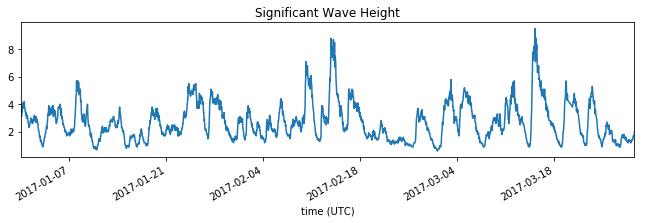

In [4]:
%matplotlib inline

ax = df['value'].plot(figsize=(11, 2.75), title=df['parameter'][0])

You may notice that slicing the time dimension on the sever side is very fast when compared with an OPeNDAP request. The downloading of the time dimension data, slice, and subsequent downloading of the actual data are all much faster.

ERDDAP also allows for filtering of the variable's values. For example, let's get Wave Heights that are bigger than 6 meters starting from 2016.

\*\* Note how we can lazily build on top of the previous query using Python's dictionaries.

In [5]:
params.update(
    {
        'value>': 6,
        'time>': '2016-01-00T00:00:00Z',
    }
)

url = encode_erddap(urlbase, fname, columns, params)

df = read_csv(url, index_col=0, parse_dates=True)

# Prevent :station: from turning into an emoji in the webpage.
df['station'] = df.station.str.split(':').str.join('_')

df.head()

,value,station,longitude (degrees_east),latitude (degrees_north),parameter,unit,depth (m)
time (UTC),,,,,,,
2017-03-15 20:00:00,6.4,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-15 19:50:00,6.4,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-15 19:00:00,6.8,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-15 18:50:00,6.8,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0
2017-03-15 18:00:00,6.4,urn_ioos_station_wmo_44011,-66.619,41.098,Significant Wave Height,m,0.0


And now we can visualize the frequency of `Significant Wave Height` greater than 6 meters by month.

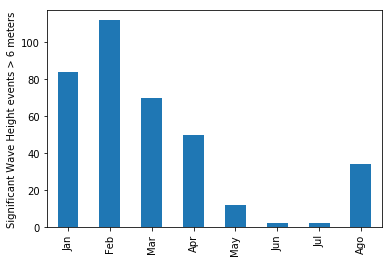

In [6]:
def key(x):
    return x.month


grouped = df['value'].groupby(key)

ax = grouped.count().plot.bar()
ax.set_ylabel('Significant Wave Height events > 6 meters')
m = ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'])

Wow! Wintertime is pretty rough out on George's Bank!

There is also a built-in relative time functionality so you can specify a specific time frame you look at. Here we demonstrate this part of the tool by getting the last 2 hours and displaying that with the `HTML` response in an `IFrame`.

In [7]:
from IPython.display import HTML


fname = 'sensor_service.htmlTable'

params = {
    'time>': 'now-2hours',
    'time<': 'now',
    'station': '"urn:ioos:station:nerrs:wqbchmet"',
    'parameter': '"Wind Speed"',
    'unit': '"m.s-1"'
}

url = encode_erddap(urlbase, fname, columns, params)

iframe = '<iframe src="{src}" width="650" height="370"></iframe>'.format
HTML(iframe(src=url))

`ERDDAP` responses are very rich. There are even multiple image formats in the automate graph responses.
Here is how to get a `.png` file for the temperature time-series. While you can specify the width and height, we chose just an arbitrary size.

In [8]:
fname = 'sensor_service.png'

params = {
    'time>': 'now-7days',
    'station': '"urn:ioos:station:wmo:44011"',
    'parameter': '"Water Temperature"',
    'unit': '"degree_Celsius"',
}


width, height = 450, 500
params.update(
    {'.size': '{}|{}'.format(width, height)}
)

url = encode_erddap(urlbase, fname, columns, params)

iframe = '<iframe src="{src}" width="{width}" height="{height}"></iframe>'.format
HTML(iframe(src=url, width=width+5, height=height+5))

This example tells us it is rough and cold out on George's Bank!

To explore more datasets, use the IOOS sensor map [website](https://sensors.ioos.us/#map)!

<br>
Right click and choose Save link as... to
[download](https://raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2017-03-21-ERDDAP_IOOS_Sensor_Map.ipynb)
this notebook, or see a static view [here](http://nbviewer.ipython.org/urls/raw.githubusercontent.com/ioos/notebooks_demos/master/notebooks/2017-03-21-ERDDAP_IOOS_Sensor_Map.ipynb).